In [23]:
import sys
import os

# Get the absolute path to the project directory
project_dir = os.path.abspath("..")

# Append the project directory to sys.path
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [24]:

import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import asdict, is_dataclass, dataclass
from pandas.api.types import is_datetime64_any_dtype
import scipy
import numpy as np
import polars as pl
from typing import Dict, List
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from src.common.AssetData import AssetData
from src.common.AssetDataPolars import AssetDataPolars
from src.common.AssetDataService import AssetDataService
from src.common.AssetFileInOut import AssetFileInOut 
from src.databaseService.OutsourceLoader import OutsourceLoader

from src.simulation.SimulatePortfolio import SimulatePortfolio
from src.strategy.StratBuyAndHold import StratBuyAndHold
from src.simulation.ResultAnalyzer import ResultAnalyzer
from src.common.AssetFileInOut import AssetFileInOut
from src.predictionModule.NextDayML import NextDayML
from src.common.DataFrameTimeOperations import DataFrameTimeOperationsPandas as DFTO
from src.predictionModule.CollectionModels import CollectionModels
from src.common.AssetFileInOut import AssetFileInOut

from src.common.AssetDataPolars import AssetDataPolars
from src.common.AssetDataService import AssetDataService
from src.predictionModule.ModelAnalyzer import ModelAnalyzer


In [25]:
assets=AssetFileInOut("../src/stockGroups/bin").loadDictFromFile("group_snp500_over20years")

# Convert to Polars for speedup
assetspl: Dict[str, AssetDataPolars] = {}
for ticker, asset in assets.items():
    assetspl[ticker]= AssetDataService.to_polars(asset)

In [26]:
nextDayML = NextDayML(assetspl)

In [27]:
loadup_name = "NextDayML_debug_test2015"
nextDayML.load_data('../src/predictionModule/bin', loadup_name)

Data and metadata loaded from ../src/predictionModule/bin\NextDayML_debug_test2015.pkl


{'NextDayML_params': {'idxLengthOneMonth': 21,
  'fouriercutoff': 15,
  'spareDatesRatio': 0.5,
  'multFactor': 8,
  'daysAfterPrediction': 1,
  'monthsHorizon': 13,
  'timesteps': 7,
  'classificationInterval': [-0.0045, 0.0045]},
 'LSTMModel_params': {'units': 256,
  'dropout': 0.1,
  'dense_units': 64,
  'activation': 'relu',
  'optimizer': 'adam',
  'loss': 'mean_absolute_error',
  'metrics': ['mae'],
  'epochs': 1000,
  'batch_size': 256,
  'early_stopping_round': 50},
 'LSTMModel_loss': 0.0009404082084074616,
 'LSTMModel_mae': 0.0009404082084074616}

In [28]:
nextDayML.X_train.shape
nextDayML.X_test.shape

(52269, 1575)

In [29]:
lgbm_params = {
                'n_estimators': 100,
                'learning_rate': 0.0005,
                'max_depth': 12,
                'num_leaves': 128,
                'colsample_bytree': 0.01,
                'subsample': 0.8,
                'lambda_l1': 0.1,  # L1 regularization
                'lambda_l2': 0.1,  # L2 regularization
                'min_split_gain': 0.01,
                'n_jobs': -1,
                'early_stopping_round': 100
            }
nextDayML.traintestLGBMModel(lgbm_params)

y_pred = nextDayML.LGBMModel.predict(nextDayML.X_test)
y_pred_proba = nextDayML.LGBMModel.predict_proba(nextDayML.X_test)

from sklearn.metrics import accuracy_score, log_loss
print(accuracy_score(nextDayML.y_test, y_pred))
print(log_loss(nextDayML.y_test, y_pred_proba))

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.568123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 382361
[LightGBM] [Info] Number of data points in the train set: 175278, number of used features: 1575
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Start training from score -1.077695
[LightGBM] [Info] Start trainin

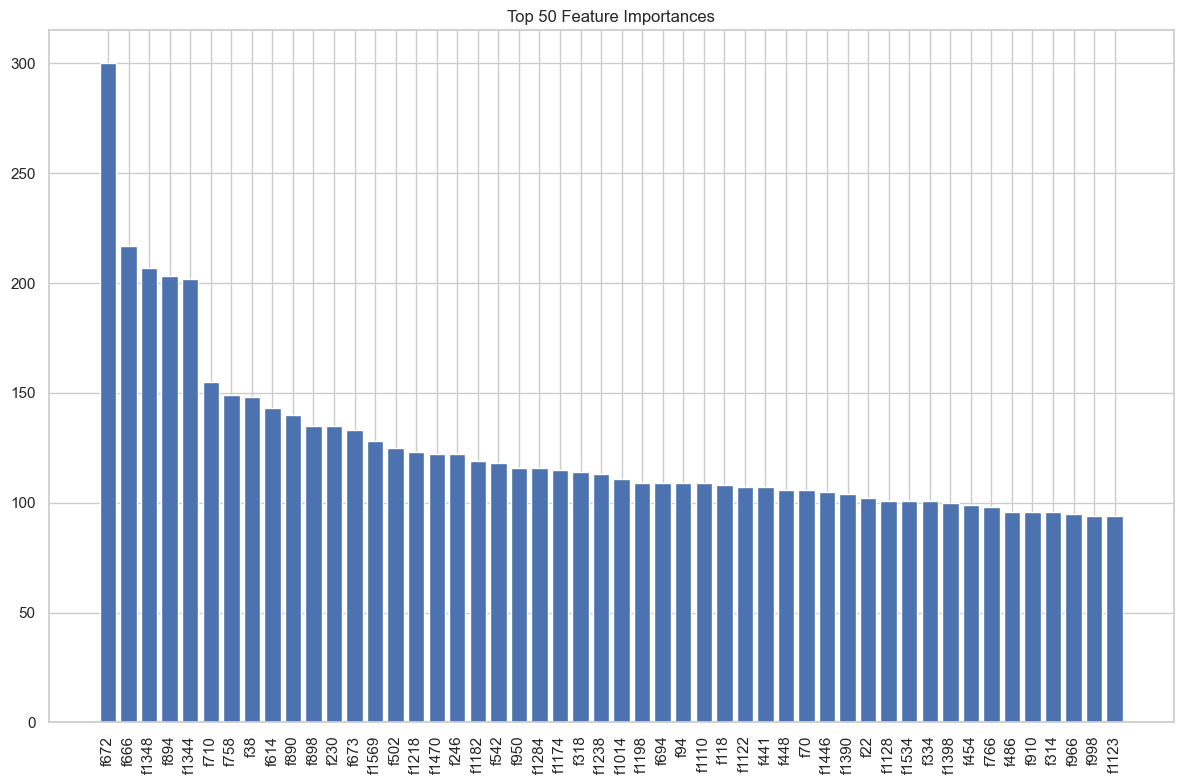

In [30]:
importances = nextDayML.LGBMModel.feature_importances_
num_features = nextDayML.X_train.shape[1]
features = [f'f{i+1}' for i in range(num_features)]
indices = np.argsort(importances)[::-1][:50]  # Top 50

# Plot top 50 feature importances
plt.figure(figsize=(12, 8))
plt.title("Top 50 Feature Importances")
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

In [31]:
import xgboost as xgb
print(nextDayML.X_train.shape[1])
xgb.plot_importance(nextDayML.XGBoostModel, max_num_features=30, height=0.5, show_values=False)

1575


NotFittedError: need to call fit or load_model beforehand

In [32]:
lstm_params = {
    'units': 256,
    'dropout': 0.1,
    'dense_units': 64,
    'activation': 'relu',
    'optimizer': 'adam',
    'loss': 'mean_absolute_error',
    'metrics': ['mae'],
    'epochs': 1000,
    'batch_size': 128,
    'early_stopping_round':30,
}
nextDayML.traintestLSTMModel(lstm_params)

c:\Users\kimer\Desktop\RandomOdyssey\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0196 - mae: 0.0196 - val_loss: 0.0016 - val_mae: 0.0016
Epoch 2/1000
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0022 - val_mae: 0.0022
Epoch 3/1000
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.0014 - mae: 0.0014 - val_loss: 0.0014 - val_mae: 0.0014
Epoch 4/1000
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.0013 - mae: 0.0013 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 5/1000
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 0.0012 - mae: 0.0012 - val_loss: 0.0016 - val_mae: 0.0016
Epoch 6/1000
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.0011 - mae: 0.0011 - val_loss: 0.0013 - val_mae: 0.0013
Epoch 7/1000
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.0011 - mae: 0.0011 - val_loss: 0.0012 - val_mae: 0.0012
Epoch 8/1000
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.0010 - mae: 0.0010 - val_loss: 0.0013 - val_mae: 0.0013
Epoch 9/

c:\Users\kimer\Desktop\RandomOdyssey\src\predictionModule\ModelAnalyzer.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=label_data, palette=palette)


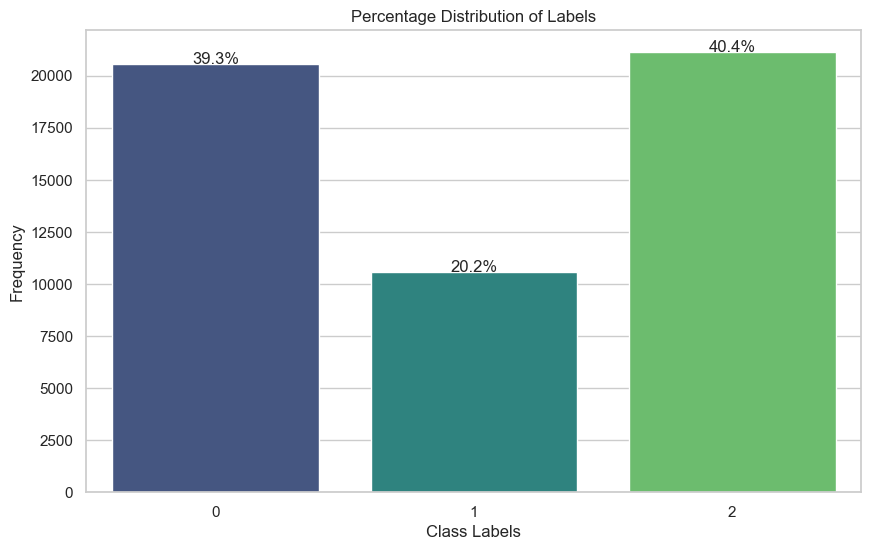

Sum of squared percentages: 0.3591


np.float64(0.35910953005271495)

In [33]:
ma = ModelAnalyzer(nextDayML)
ma.plot_label_distribution(label_data=nextDayML.y_test)

1634/1634 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


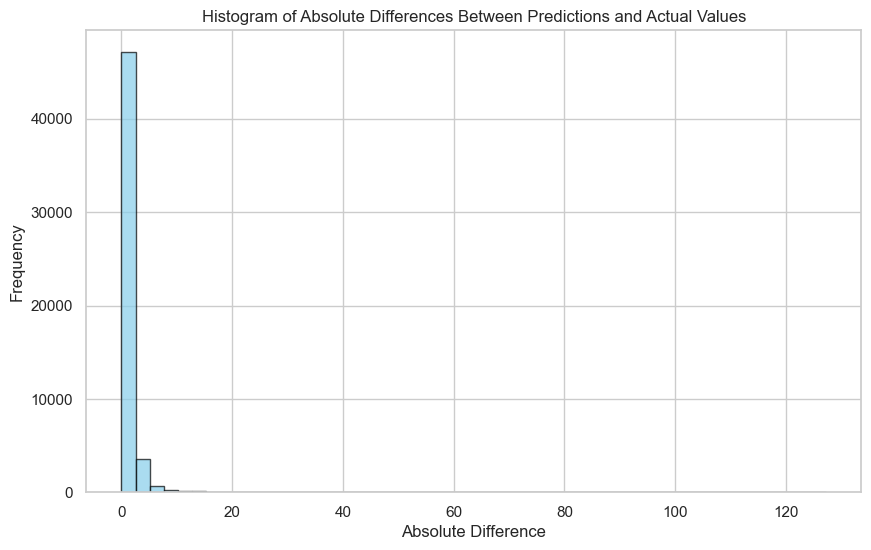

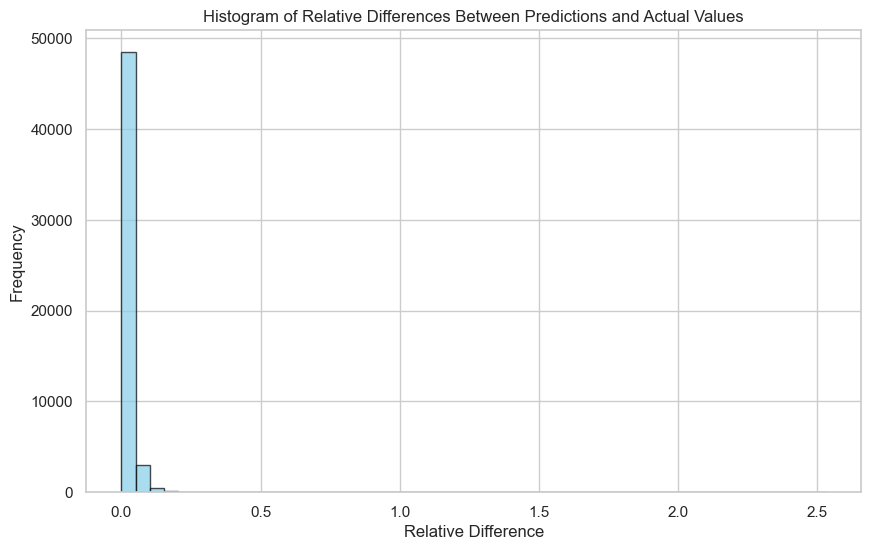

In [34]:
ma.plot_lstm_absolute_diff_histogram()

In [35]:

X_test: np.array = nextDayML.X_test_timeseries
y_test: np.array = nextDayML.y_test_timeseries  # shape (:,1)

num_samples, timesteps, num_features = X_test.shape

X_test_flat = X_test.reshape(num_samples, -1)
X_test_scaled_flat = nextDayML.scaler_X.transform(X_test_flat)
X_test_scaled = X_test_scaled_flat.reshape(num_samples, timesteps, num_features)

predictions_scaled = nextDayML.LSTMModel.predict(X_test_scaled)
predictions = nextDayML.scaler_y.inverse_transform(predictions_scaled)

1634/1634 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [36]:
pred_bias = predictions

a=np.array([y_test, pred_bias])
a.reshape(y_test.shape[0],-1)
b=(a.T)[0]

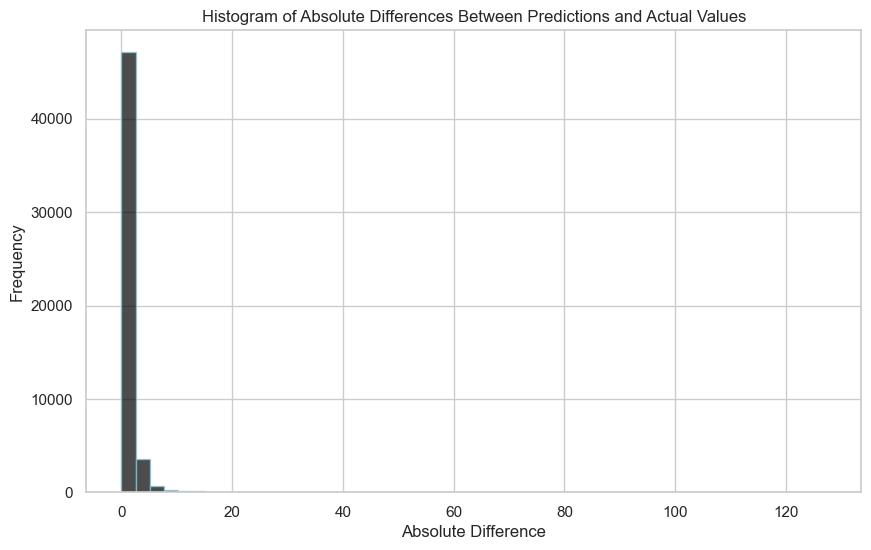

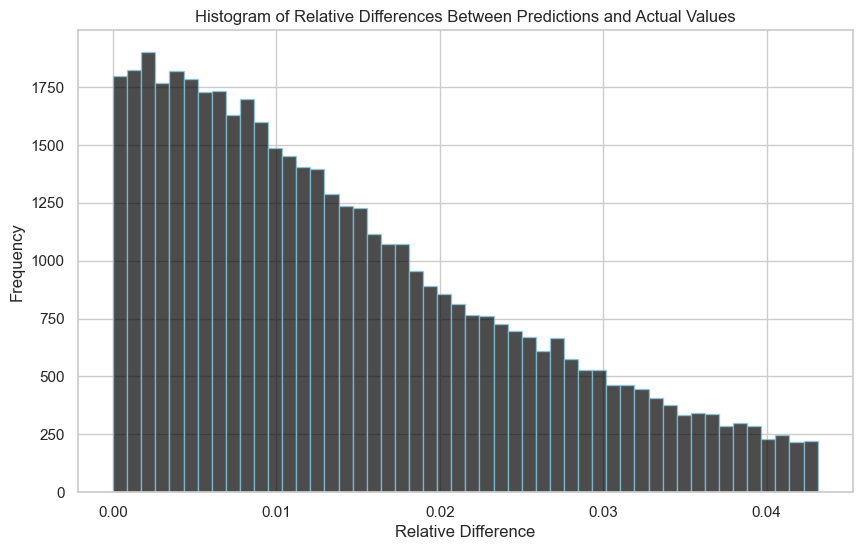

In [37]:
abs_diff = np.abs(pred_bias.flatten() - y_test.flatten())
rel_diff = abs_diff / np.abs(y_test.flatten())

# Filter data to only include the 25th to 75th quantile range
lower_quantile = np.percentile(rel_diff, 0)
upper_quantile = np.percentile(rel_diff, 90)
filtered_rel_diff = rel_diff[(rel_diff >= lower_quantile) & (rel_diff <= upper_quantile)]

# Plot the histogram of absolute differences
plt.figure(figsize=(10,6))
plt.hist(abs_diff, bins=50, color='black', edgecolor='skyblue', alpha=0.7)
plt.title('Histogram of Absolute Differences Between Predictions and Actual Values')
plt.xlabel('Absolute Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot the histogram of relative differences
plt.figure(figsize=(10,6))
plt.hist(filtered_rel_diff, bins=50, color='black', edgecolor='skyblue', alpha=0.7)
plt.title('Histogram of Relative Differences Between Predictions and Actual Values')
plt.xlabel('Relative Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [42]:
print(filtered_rel_diff.mean())
print(nextDayML.X_test_timeseries.shape)
print(225/7)

0.014352023587381009
(52269, 7, 225)
32.142857142857146


In [43]:
pastprices = nextDayML.X_test_timeseries[:,-1,0]

divPrices = predictions.reshape(-1)/pastprices.reshape(-1)-1

divClass = nextDayML.getTargetFromPrice(np.array(divPrices),nextDayML.classificationInterval)

error = np.abs(divClass-nextDayML.y_test)

c:\Users\kimer\Desktop\RandomOdyssey\src\predictionModule\ModelAnalyzer.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=label_data, palette=palette)


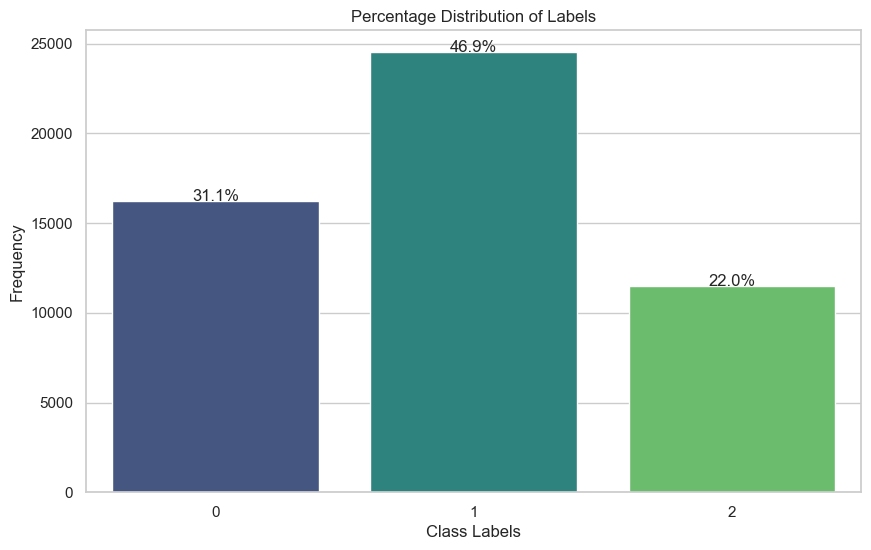

Sum of squared percentages: 0.3651


np.float64(0.3651075241709457)

In [44]:
ma.plot_label_distribution(label_data=error)

Check how likely it is that predition of the return is >3%  then the actual prediction is > 1% as well
We do not explicitly use Bayes' Rule in the calculation. Instead, we used the definition of conditional probability directly.

In [59]:
lastprices = nextDayML.X_test_timeseries[:,-1,0].reshape(-1)
predictions = predictions.reshape(-1)
actualPrice = nextDayML.y_test_timeseries.reshape(-1)

predicted_returns = (predictions - lastprices) / lastprices

# Step 2: Calculate Actual Returns
actual_returns = (actualPrice - lastprices) / lastprices

# Step 3: Apply Conditions
predPerc = 0.09
actualPerc = 0.01
condition_pred_gt_3 = predicted_returns > predPerc
condition_actual_gt_1 = actual_returns > actualPerc

# Number of times predicted return > predPerc
num_pred_gt_3 = np.sum(condition_pred_gt_3)

# Number of times actual return > actualPerc when predicted return > predPerc
num_both_conditions = np.sum(condition_pred_gt_3 & condition_actual_gt_1)

# Step 4: Calculate Probability
if num_pred_gt_3 > 0:
    probability = num_both_conditions / num_pred_gt_3
else:
    probability = 0  # Avoid division by zero if no predictions > 3%

print(f"The probability that the actual return is >{actualPerc} given that the predicted return is >{predPerc} is {probability:.2%}")


The probability that the actual return is >0.01 given that the predicted return is >0.09 is 68.18%
